# Imports

In [52]:
import torch
import math
import warnings
import random
import time
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood

import numpy as np
from matplotlib import pyplot as plt

import warnings

## Objective Functions (Most relevant: Rosenbrock, Ackley, Bird)

In [3]:
# Cases for Objective Functions
def rosenbrock(x, y, a=1, b=100):#Domain: [[-2,2],[-1,3]], global max: f(1,1)=0
    return -((a - x) ** 2 + b * (y - x ** 2) ** 2)

def ackley(x, y, a=20, b=0.2, c=2*np.pi): #Domain: [-5,5],[-5,5]], global max: f(0,0)=0
    return -(-a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y))) + np.e + a)


def bird(x1,x2):
    term1 = np.sin(x2) * np.exp((1 - np.cos(x1)) ** 2)
    term2 = np.cos(x1) * np.exp((1 - np.sin(x2)) ** 2)
    term3 = (x1 - x2) ** 2
    return -(term1 + term2 + term3) -106.7645367 #to shift value

def obj1DParab(x): #Domain: [-10,10]
    return -x*x

def obj1D2Peak1(x): #Domain: [-10,10]
    return -1/10*((x-7.6)**2)*(x+2)*(x+9.2)-241.579

def obj1D2Peak2(x): #Domain: [-10,10]
    return obj1D2Peak1(-x)

def pickObjFunc(s):
    if s=='ackley':
        return ackley
    if s=='rosenbrock':
        return rosenbrock
    if s=='bird':
        return bird
    if s=='1DParab':
        return obj1DParab
    if s=='1D2Peak1':
        return obj1D2Peak1
    if s=='1D2Peak2':
        return obj1D2Peak2

def getDomain(s):
    if s=='ackley':
        return [[-5,5],[-5,5]]
    if s=='rosenbrock':
        return [[-2,2],[-1,3]]
    if s=='bird':
        return [[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]]
    if s=='1DParab':
        return [-10,10]
    if s=='1D2Peak1':
        return [-10,10]
    if s=='1D2Peak2':
        return [-10,10]

def getDiscSpace(domain, discSize):
    x=torch.linspace(domain[0][0],domain[0][1],discSize)
    y=torch.linspace(domain[1][0],domain[1][1],discSize)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    return grid_points

# Regret

## Regret Definitions

In [4]:
# Regret Definitions

def regretBestInstant(dataH):
    T=len(dataH[0])
    reg=np.zeros((T-1,1))
    numAgents=len(dataH)
    for i in range(T-1):
        maxObj=-np.infty
        for j in range(numAgents):
            for k in range(i+1):
                if dataH[j][k][1]>maxObj:
                    maxObj=dataH[j][k][1] 
        reg[i,0]=max(0,0-maxObj)
    return reg
        
    
def regretCumulative(reg):
    T=len(reg)
    regCum=np.zeros((T,1))
    for i in range(T):
        regCum[i,0]=np.sum(reg[0:i+1,0])
    return regCum

def regretSumInstant(dataH):
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        s=0
        for j in range(numAgents):
            s+=dataH[j][i][1]
        reg[i,0]=0-s
    return reg


def regretAvgInstant(dataH):
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        s=0
        for j in range(numAgents):
            s+=dataH[j][i][1]
        reg[i,0]=(0-s)/numAgents
    return reg

def worstRegret(dataH):
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((T,1))
    for i in range(T):
        minObj=np.infty
        for j in range(numAgents):
            if dataH[j][i][1]<minObj:
                minObj=dataH[j][i][1]
        reg[i,0]=0-minObj
    return reg

def getAllRegrets(dataH):
    regHI=regretBestInstant(dataH)
    regHCum=regretCumulative(regHI)
    regSumI=regretSumInstant(dataH)
    regSumCum=regretCumulative(regSumI)
    regAvgI=regretAvgInstant(dataH)
    regAvgCum=regretCumulative(regAvgI)
    regWorstI=worstRegret(dataH)
    regWorstCum=regretCumulative(regWorstI)
    return regHI,regHCum,regSumI,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum

def allAgentsRegretSingleTimeDependent(dataH):
    T=len(dataH[0])
    numAgents=len(dataH)
    reg=np.zeros((numAgents,T))
    for i in range(numAgents):
        agentHist=dataHist[i]
        for j in range(T):
            reg[i][j]=-agentHist[j][1]
    return reg
        

## Regret Plots

In [22]:
def plotRegretsEachAgent(dataH):
    regAll=allAgentsRegretSingleTimeDependent(dataH)
    for i in range(reg.shape()[0]):
        plt.plot(regAll[i],label=str(i))
    plt.xlabel("iterations")
    plt.ylabel("instant regret (Best)")
    plt.show()



def plotRegretsSingleCase(dataH):
    regInst,regCum,regInstSum,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum=getAllRegrets(dataH)
    plt.plot(regInst)
    plt.xlabel("iterations")
    plt.ylabel("instant regret (Best)")
    plt.show()

    plt.plot(regCum)
    plt.xlabel("iterations")
    plt.ylabel("cumulative regret (Best)")
    plt.show()

    plt.plot(regInstSum)
    plt.xlabel("iterations")
    plt.ylabel("instant regret (Sum)")
    plt.show()

    plt.plot(regSumCum)
    plt.xlabel("iterations")
    plt.ylabel("cumulative regret (Sum)")
    plt.show()

    plt.plot(regWorstI)
    plt.xlabel("iterations")
    plt.ylabel("worst regret (instant)")
    plt.show()
    
    plt.plot(regWorstCum)
    plt.xlabel("iterations")
    plt.ylabel("worst regret (Sum)")
    plt.show()
    
def plotRegretsMultCase(dataHists,label):
    regInsts,regCums,regInstSums,regSumCums,regAvgInsts,regAvgCums,regWorstIs,regWorstCums=[],[],[],[],[],[],[],[]
    for i in range(len(dataHists)):
        regInst,regCum,regInstSum,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum=getAllRegrets(dataHists[i])
        regInsts.append(regInst)
        regCums.append(regCum)
        regInstSums.append(regInstSum)
        regSumCums.append(regSumCum)
        regAvgInsts.append(regAvgI)
        regAvgCums.append(regAvgCum)
        regWorstIs.append(regWorstI)
        regWorstCums.append(regWorstCum)
    
    
    for i in range(len(regInsts)):
        plt.plot(regInsts[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("instant best regret")
    plt.legend()
    plt.show()

    for i in range(len(regCums)):
        plt.plot(regCums[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("cumulative best regret")
    plt.legend()
    plt.show()

    
    for i in range(len(regInstSums)):
        plt.plot(regInstSums[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("instant summed regret")
    plt.legend()
    plt.show()

    for i in range(len(regSumCums)):
        plt.plot(regSumCums[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("cumulative summed regret")
    plt.legend()
    plt.show()    

    for i in range(len(regAvgInts)):
        plt.plot(regAvgInts[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("instant avg regret")
    plt.legend()
    plt.show()

    for i in range(len(regAvgCums)):
        plt.plot(regAvgCums[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("cumulative avg regret")
    plt.legend()
    plt.show()
    
    for i in range(len(regWorstIs)):
        plt.plot(regWorstIs[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("instant worst regret")
    plt.legend()
    plt.show()

    for i in range(len(regWorstCums)):
        plt.plot(regWorstCums[i],label=label[i])
        plt.xlabel("iterations")
        plt.ylabel("cumulative worst regret")
    plt.legend()
    plt.show()     
    
    
    
def plotRegretsMultCaseWithVar(dataHists,label):
    regInsts,regCums,regInstSums,regSumCums,regAvgInsts,regAvgCums,regWorstIs,regWorstCums=[],[],[],[],[],[],[],[]
    for i in range(len(dataHists)):
        regInsts1,regCums1,regInstSums1,regSumCums1,regAvgInsts1,regAvgCums1,regWorstIs1,regWorstCums1=[],[],[],[],[],[],[],[]
        for j in range(len(dataHists[i])):
            regInst,regCum,regInstSum,regSumCum,regAvgI,regAvgCum,regWorstI,regWorstCum=getAllRegrets(dataHists[i][j])
            regInsts1.append(regInst)
            regCums1.append(regCum)
            regInstSums1.append(regInstSum)
            regSumCums1.append(regSumCum)
            regAvgInsts1.append(regAvgI)
            regAvgCums1.append(regAvgCum)
            regWorstIs1.append(regWorstI)
            regWorstCums1.append(regWorstCum)
        regInsts.append(regInsts1)
        regCums.append(regCums1)
        regInstSums.append(regInstSums1)
        regSumCums.append(regSumCums1)
        regAvgInsts.append(regAvgInsts1)
        regAvgCums.append(regAvgCums1)
        regWorstIs.append(regWorstIs1)
        regWorstCums.append(regWorstCums1)
    
    def miniPlot(reg,yAx,label):
        for i in range(len(reg)):
            mean=np.mean(np.array(reg[i]), axis=0).flatten()
            std=np.std(np.array(reg[i]), axis=0).flatten()
            plt.plot(mean,label=label[i])
            plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.2)
            plt.xlabel("iterations")
            plt.ylabel(yAx)
            plt.ylim(bottom=-.1)
        plt.legend()
        plt.show()
    
    miniPlot(regInsts, 'instant best regret', label)
    miniPlot(regCums, 'cumulative best regret', label)
    miniPlot(regInstSums, 'instant summed regret', label)    
    miniPlot(regSumCums, 'cumulative summed regret', label)
    miniPlot(regAvgInsts, 'instant average regret', label)
    miniPlot(regAvgCums, 'cumulative average regret', label)
    miniPlot(regWorstIs, 'instant worst regret', label)
    miniPlot(regWorstCums, 'cumulative worst regret', label)
    




# Auxiliary Functions

In [6]:
def edgelistToAdjMtx(numAgents,edgeList):
    adjMtx=np.zeros((numAgents,numAgents))
    for vtxPair in edgeList:
        i,j=vtxPair
        adjMtx[i,j]=1
        adjMtx[j,i]=1
    return adjMtx

# Inefficient; can use DFS and check visited vertex list. But this uses cool combinatoric trick
def checkConnectivity(numAgents,edgeList):
    adjMtx=edgelistToAdjMtx(numAgents,edgeList)
    res=np.linalg.matrix_power(adjMtx,numAgents-1)+np.linalg.matrix_power(adjMtx,numAgents-2)
    return np.all(res>0)

def makeCommGraph(numAgents,graph,connectProb=0.25,seed=0):#0 indexed
    adjMtx=np.zeros((numAgents,numAgents))
    edgeList=[]
    if graph=='linear':
        edgeList=[(i,i+1) for i in range(numAgents-1)]
    if graph=='star':
        edgeList=[(0,i) for i in range(1,numAgents)]
    if graph=='complete':
        edgeList=[(i,j) for i in range(numAgents) for j in range(i+1,numAgents)]
    if graph=='disjoint':
        edgeList=[]
    if graph=='erdos-renyi':
        random.seed(seed)
        connected=False
        while not connected:
            edgeList=[(i,j) for i in range(numAgents) for j in range(i+1,numAgents) if random.random()<connectProb]
            connected=checkConnectivity(numAgents,edgeList)
    return edgelistToAdjMtx(numAgents,edgeList)

def commDataForAgent(agent,commGraph,commHist,dataHist,t):
    agentData=[]
    agentObs=[]
    neighbors=commGraph[agent,:]
    agentData=dataHist[agent][t][0].unsqueeze(0)
    agentObs=dataHist[agent][t][1].unsqueeze(0)
    for i in range(len(neighbors)):
        if(neighbors[i]==1):
            agentData=torch.cat([agentData,commHist[i][t][0].unsqueeze(0)])
            agentObs=torch.cat([agentObs,commHist[i][t][1].unsqueeze(0)])

    return agentData,agentObs 

def admissiblePoints(admissRad,discSpace,refPoint):
    distances = torch.norm(discSpace - refPoint, dim=1)

    within_distance_indices = torch.where(distances <= admissRad)[0]

    return discSpace[within_distance_indices]

In [27]:
makeCommGraph(1,'star')

array([[0.]])

In [9]:
def runBO(numAgents=5,initSize=10,totalT=100,discSize=100,eps=.1,graph='complete',seed=0,objFunc='ackley',admissRad=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    commGraph=graph
    objective=pickObjFunc(objFunc)
    domain=getDomain(objFunc)
    discSpace=getDiscSpace(domain,discSize)
    
    visitHist=[[] for i in range(numAgents)]
    commHist=[[] for i in range(numAgents)]
    updateHistPts=[[] for i in range(numAgents)]
    updateHistVals=[[] for i in range(numAgents)]
    gpList=[]
    for agent in range(numAgents):
        train_X1=torch.rand(initSize, 1, dtype=torch.double)*(domain[0][1]-domain[0][0])+domain[0][0]
        train_X2=torch.rand(initSize, 1, dtype=torch.double)*(domain[1][1]-domain[1][0])+domain[1][0]
        train_X=torch.cat((train_X1,train_X2),dim=1)
        trainYs=[[objective(train_X[i][0].item(),train_X[i][1].item())+torch.randn(1)*eps] for i in range(len(train_X))]
        train_Y=torch.tensor(trainYs,dtype=torch.double)
        gp=SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        likelihood=GaussianLikelihood(),
        input_transform=Normalize(d=2),
        outcome_transform=Standardize(m=1),
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        gp(train_X)
        gpList.append(gp)
        best_index = torch.argmax(train_Y)
        visitHist[agent].append((train_X[best_index],train_Y[best_index]))
        commHist[agent].append((train_X[best_index],train_Y[best_index]))
        updateHistPts[agent]=train_X
        updateHistVals[agent]=train_Y

    for t in range(totalT):
        for agent in range(numAgents):
            agentData, agentObs=commDataForAgent(agent,commGraph,commHist,visitHist,t)
            
            updateHistPts[agent]=torch.cat([updateHistPts[agent], agentData])
            updateHistVals[agent]=torch.cat([updateHistVals[agent], agentObs])

            gpList[agent] = SingleTaskGP(
            train_X=updateHistPts[agent],
            train_Y=updateHistVals[agent],
            likelihood=GaussianLikelihood(),
            input_transform=Normalize(d=2),
            outcome_transform=Standardize(m=1),
            )
            mll = ExactMarginalLogLikelihood(gpList[agent].likelihood, gpList[agent])
            fit_gpytorch_mll(mll)
            
            #TS
            candidatePoints=admissiblePoints(admissRad,discSpace,visitHist[agent][t][0]) 
            posterior_samples = torch.zeros(candidatePoints.size(0))
            for j, point in enumerate(candidatePoints):
                posterior = gpList[agent].posterior(point.unsqueeze(0))
                posterior_samples[j] = posterior.rsample(sample_shape=torch.Size([1]))
            # Find the maximum of the posterior samples
            max_index = torch.argmax(posterior_samples)
            max_point = candidatePoints[max_index]
            #evaluate objective function where we think max value is
            objVal=objective(max_point[0],max_point[1])+torch.randn(1)*eps

            #pick point to communicate to other agents:
            
            #update dataHistory 
            visitHist[agent].append((max_point,objVal))
            commHist[agent].append((max_point,objVal))
        #print(f"{t}/{totalT}")

    print(f"completed runBO with {objFunc} objective function, {graph} graph, {numAgents} agents, {totalT} iterations")
    return visitHist
    

In [10]:
def runBOHighVar(numAgents=5,initSize=10,totalT=100,discSize=100,eps=.1,graph='complete',seed=0,objFunc='ackley',admissRad=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    commGraph=graph
    objective=pickObjFunc(objFunc)
    domain=getDomain(objFunc)
    discSpace=getDiscSpace(domain,discSize)
    
    visitHist=[[] for i in range(numAgents)]
    commHist=[[] for i in range(numAgents)]
    updateHistPts=[[] for i in range(numAgents)]
    updateHistVals=[[] for i in range(numAgents)]
    gpList=[]
    for agent in range(numAgents):
        train_X1=torch.rand(initSize, 1, dtype=torch.double)*(domain[0][1]-domain[0][0])+domain[0][0]
        train_X2=torch.rand(initSize, 1, dtype=torch.double)*(domain[1][1]-domain[1][0])+domain[1][0]
        train_X=torch.cat((train_X1,train_X2),dim=1)
        trainYs=[[objective(train_X[i][0].item(),train_X[i][1].item())+torch.randn(1)*eps] for i in range(len(train_X))]
        train_Y=torch.tensor(trainYs,dtype=torch.double)
        gp=SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        likelihood=GaussianLikelihood(),
        input_transform=Normalize(d=2),
        outcome_transform=Standardize(m=1),
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        gp(train_X)
        gpList.append(gp)
        best_index = torch.argmax(train_Y)
        visitHist[agent].append((train_X[best_index],train_Y[best_index]))
        commHist[agent].append((train_X[best_index],train_Y[best_index]))
        updateHistPts[agent]=train_X
        updateHistVals[agent]=train_Y

    for t in range(totalT):
        for agent in range(numAgents):
            agentData, agentObs=commDataForAgent(agent,commGraph,commHist,visitHist,t)

            #update commhist based on which point has max posterior variance
            posterior=gpList[agent].posterior(agentData)
            maxVarInd=torch.argmax(posterior.variance)
            maxVarPt=agentData[maxVarInd]
            maxVarVal=agentObs[maxVarInd]

            updateHistPts[agent]=torch.cat([updateHistPts[agent], agentData])
            updateHistVals[agent]=torch.cat([updateHistVals[agent], agentObs])

            gpList[agent] = SingleTaskGP(
            train_X=updateHistPts[agent],
            train_Y=updateHistVals[agent],
            likelihood=GaussianLikelihood(),
            input_transform=Normalize(d=2),
            outcome_transform=Standardize(m=1),
            )
            mll = ExactMarginalLogLikelihood(gpList[agent].likelihood, gpList[agent])
            fit_gpytorch_mll(mll)
            
            #TS
            candidatePoints=admissiblePoints(admissRad,discSpace,visitHist[agent][t][0]) 
            posterior_samples = torch.zeros(candidatePoints.size(0))

            for j, point in enumerate(candidatePoints):
                posterior = gpList[agent].posterior(point.unsqueeze(0))
                posterior_samples[j] = posterior.rsample(sample_shape=torch.Size([1]))
                
            # Find the maximum of the posterior samples
            max_index = torch.argmax(posterior_samples)
            max_point = candidatePoints[max_index]
            #evaluate objective function where we think max value is
            objVal=objective(max_point[0],max_point[1])+torch.randn(1)*eps
            
            #update dataHistory 
            visitHist[agent].append((max_point,objVal))

            commHist[agent].append((maxVarPt,maxVarVal))
        #print(f"{t}/{totalT}")
    print(f"completed high variance runBO with {objFunc} objective function, {graph} graph, {numAgents} agents, {totalT} iterations")        
    return visitHist
    

# Executions!

## Paper Figures

In [ ]:
# Ackley on star graph configuration with varying agent size

In [52]:
numTrials=5
agentSizes=[1,3,5,7]

ackley_star=[]
warnings.filterwarnings("ignore") #error messages of form: /opt/anaconda3/envs/saba/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
#jitter goes up to 1.0e-03
for i in agentSizes:
    g=makeCommGraph(i,'star')
    agentDataH=[runBO(numAgents=i,initSize=10,totalT=100,discSize=100,eps=1,graph=g,seed=j,objFunc='ackley',admissRad=.5) for j in range(numTrials)]
    ackley_star.append(agentDataH)
    print(f"Finished {i} agent case")
warnings.filterwarnings("default")

completed runBO with ackley objective function, star graph, 1 agents, 100 iterations
completed runBO with ackley objective function, star graph, 1 agents, 100 iterations
completed runBO with ackley objective function, star graph, 1 agents, 100 iterations
completed runBO with ackley objective function, star graph, 1 agents, 100 iterations
completed runBO with ackley objective function, star graph, 1 agents, 100 iterations
Finished 1 agent case
completed runBO with ackley objective function, star graph, 3 agents, 100 iterations
completed runBO with ackley objective function, star graph, 3 agents, 100 iterations
completed runBO with ackley objective function, star graph, 3 agents, 100 iterations
completed runBO with ackley objective function, star graph, 3 agents, 100 iterations
completed runBO with ackley objective function, star graph, 3 agents, 100 iterations
Finished 3 agent case
completed runBO with ackley objective function, star graph, 5 agents, 100 iterations
completed runBO with 

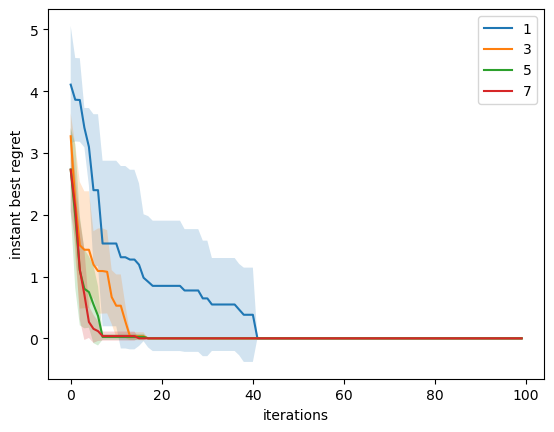

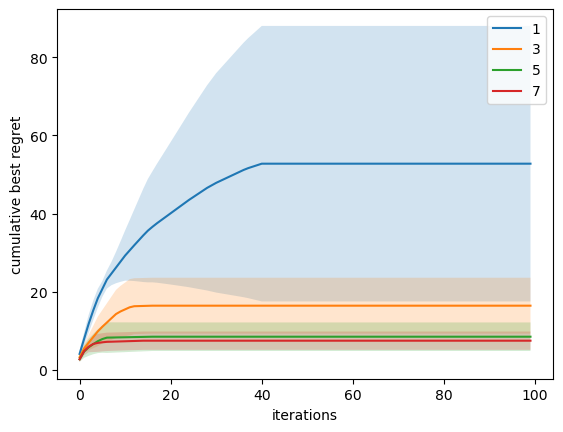

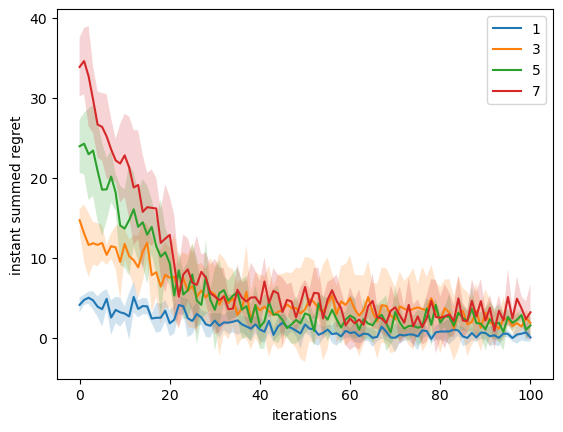

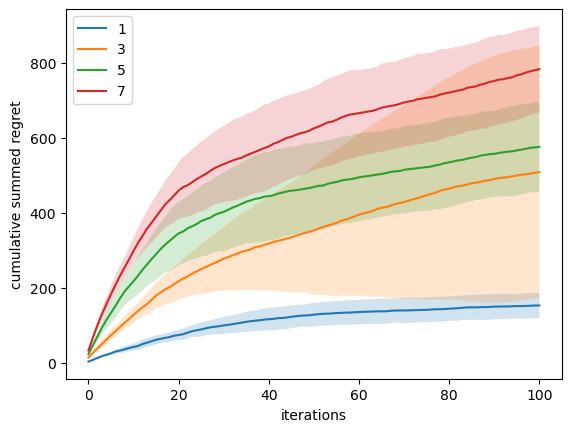

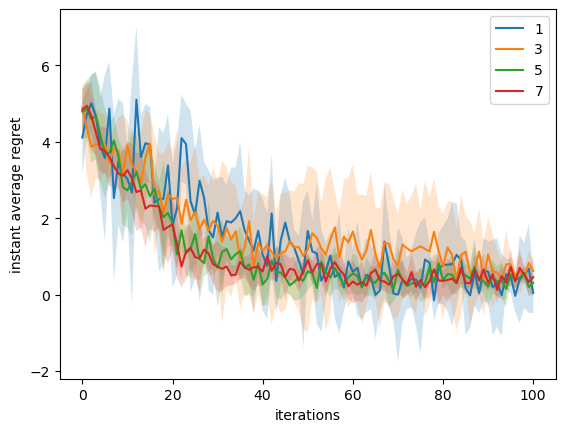

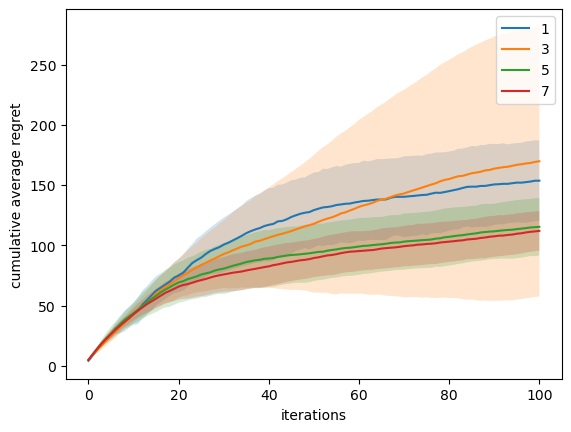

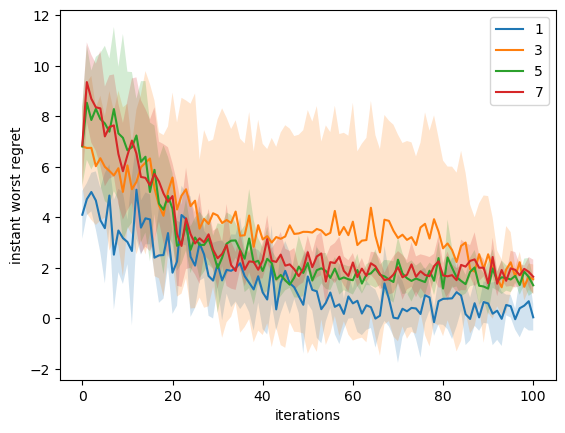

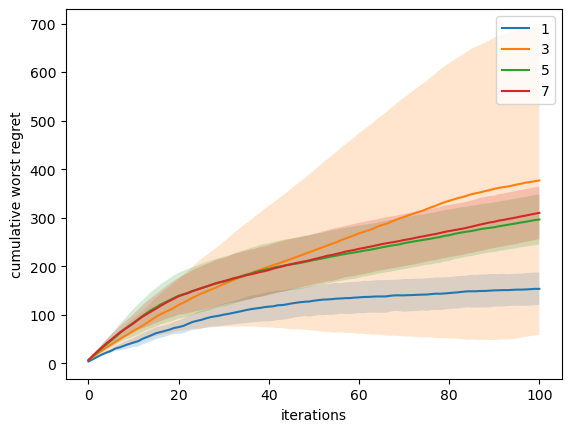

In [53]:
plotRegretsMultCaseWithVar(ackley_star,[i for i in agentSizes])

In [47]:
numTrials=5
agentSizes=[1,3,5,7]

ros_star=[]
warnings.filterwarnings("ignore") #error messages of form: /opt/anaconda3/envs/saba/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
#jitter goes up to 1.0e-03
for i in agentSizes:
    g=makeCommGraph(i,'star')
    agentDataH=[runBO(numAgents=i,initSize=10,totalT=50,discSize=100,eps=.1,graph=g,seed=j,objFunc='rosenbrock',admissRad=.5) for j in range(numTrials)]
    ros_star.append(agentDataH)
    print(f"Finished {i} agent case")
warnings.filterwarnings("default")

completed runBO with rosenbrock objective function, star graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 1 agents, 50 iterations
Finished 1 agent case
completed runBO with rosenbrock objective function, star graph, 3 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 3 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 3 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 3 agents, 50 iterations
completed runBO with rosenbrock objective function, star graph, 3 agents, 50 iterations
Finished 3 agent case
completed runBO with rosenbrock objective function, star graph, 5 agents, 50

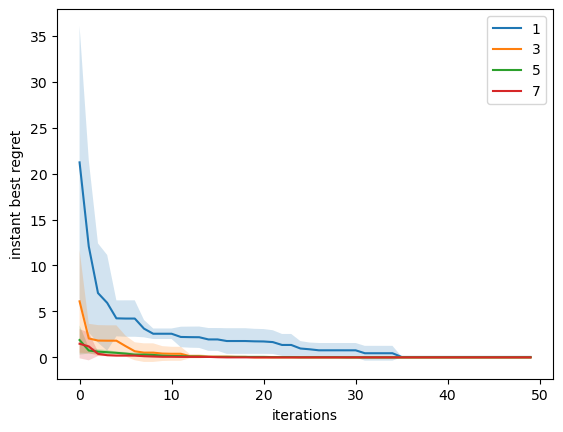

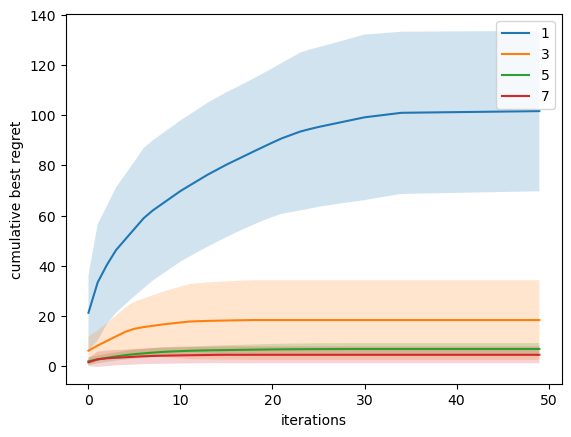

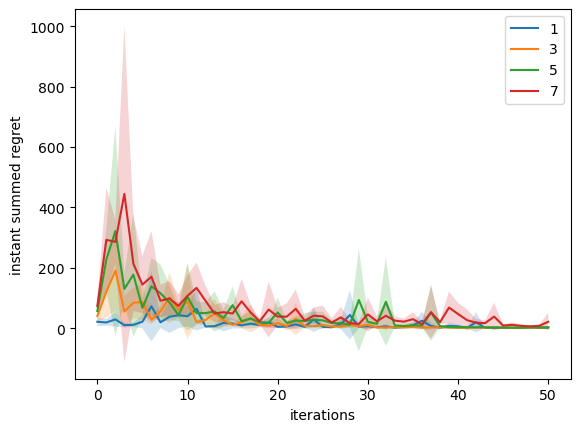

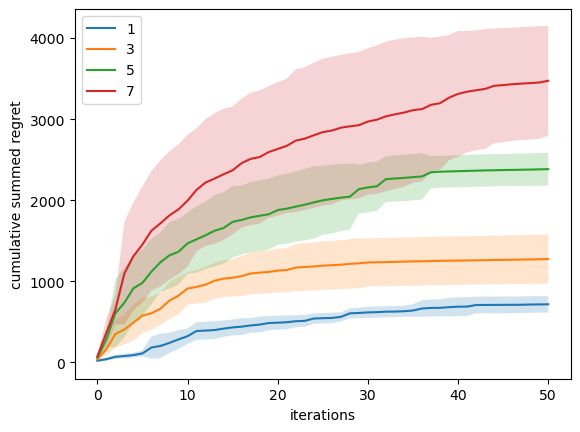

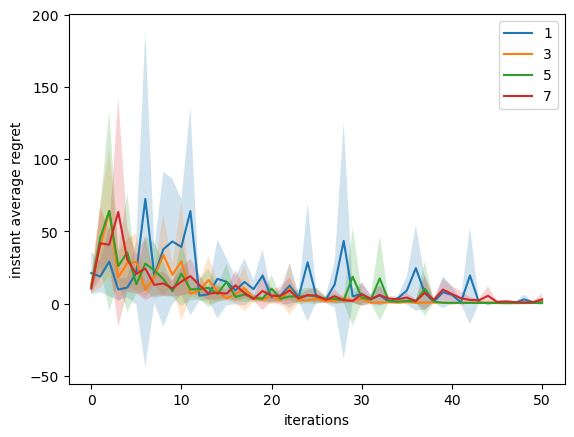

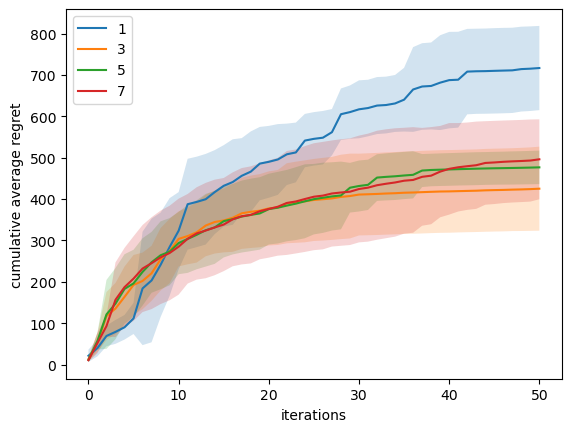

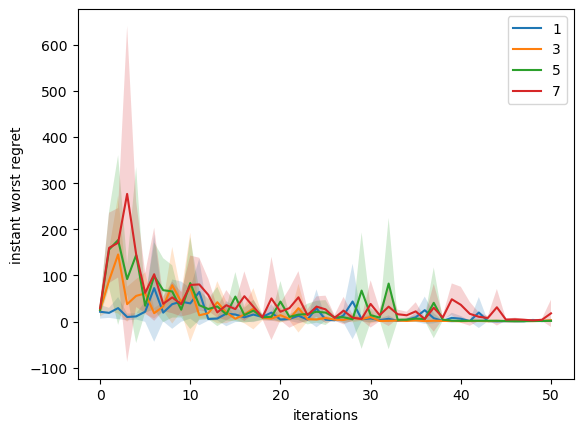

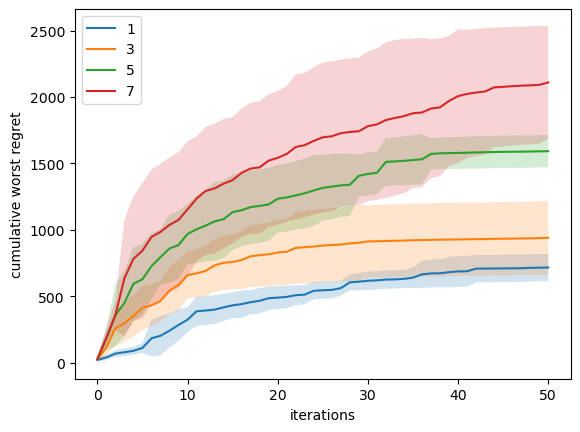

In [54]:
plotRegretsMultCaseWithVar(ros_star,[i for i in agentSizes])

# Erdos-Renyi Experimentation

## Vary N Fix p

1. Fix Connectivity Probability p=0.25
2. Loop through agents N
3. Generate 5 random graphs of N agents in random graph
4. Do 5 trials per 5 random graphs etc. per agent
5. Profit
   

In [59]:
start=time.time()
numTrials=5
agentSizes=[5,10,15,20]

ackley_ER=[]
warnings.filterwarnings("ignore") #error messages of form: /opt/anaconda3/envs/saba/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
#jitter goes up to 1.0e-03

#im doing singe separately because erdos-renyi graph function doesn't work with 1 agent
ackley_oneAgent=[runBO(numAgents=1,initSize=10,totalT=50,discSize=100,eps=1,graph=np.array([[0]]),seed=j,objFunc='ackley',admissRad=.5) for j in range(numTrials**2)]
ackley_ER.append(ackley_oneAgent)
#iterate through number of agents
for i in agentSizes:
    agentDataH=[]
    for k in range(numTrials):
        ER=makeCommGraph(i,'erdos-renyi',connectProb=0.25,seed=8*k+10)
        agentDataH+=[runBO(numAgents=i,initSize=10,totalT=50,discSize=100,eps=1,graph=ER,seed=j,objFunc='ackley',admissRad=.5) for j in range(numTrials)]
    ackley_ER.append(agentDataH)
    print(f"Finished {i} agent case")

print(time.time()-start)


completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with ackley objective function, [[0]] graph, 1 ag

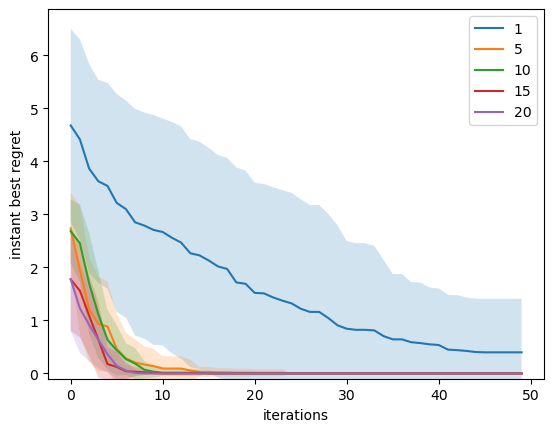

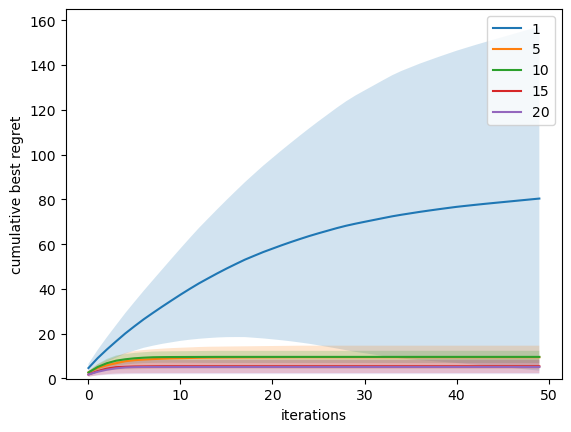

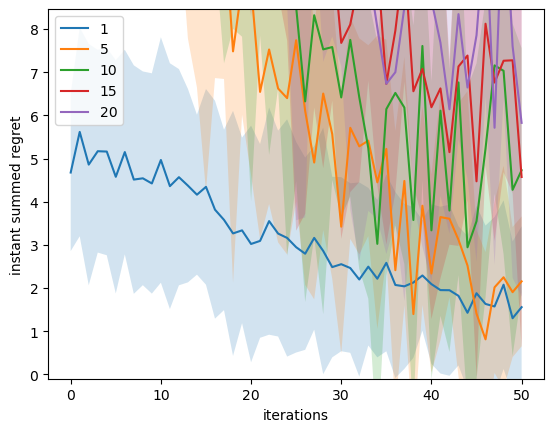

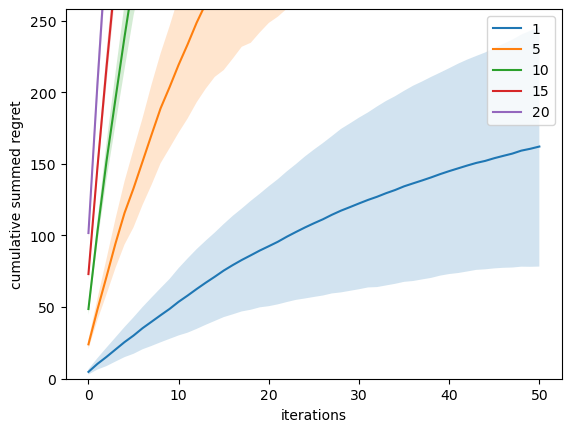

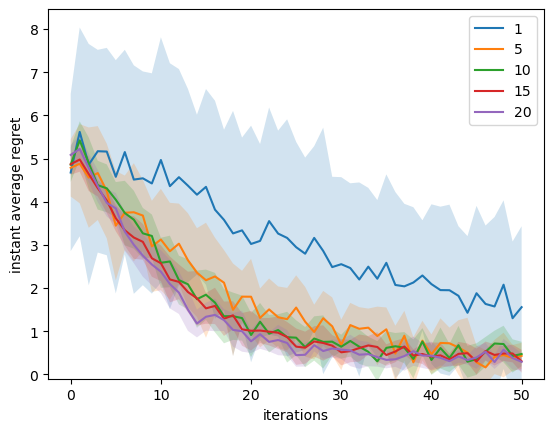

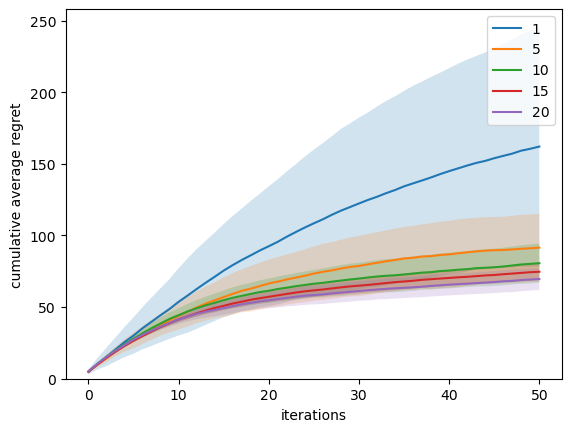

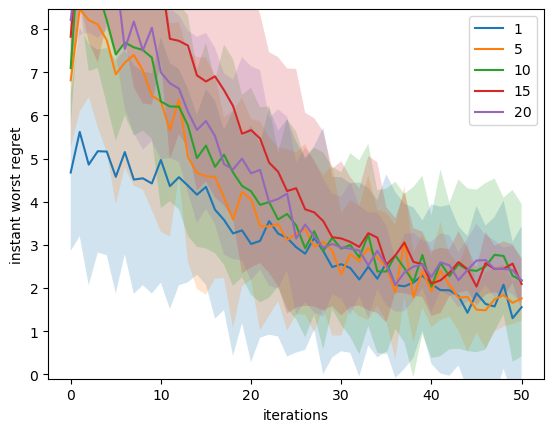

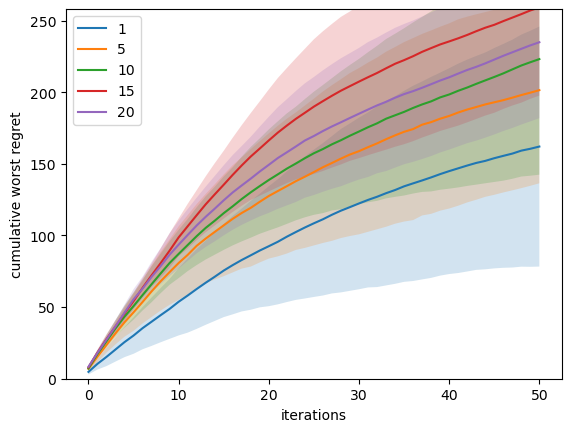

In [60]:
plotRegretsMultCaseWithVar(ackley_ER,[i for i in [1]+agentSizes])

In [62]:
start=time.time()
numTrials=5
agentSizes=[5,10,15,20]

ros_ER=[]
warnings.filterwarnings("ignore") #error messages of form: /opt/anaconda3/envs/saba/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
#jitter goes up to 1.0e-03

#im doing singe separately because erdos-renyi graph function doesn't work with 1 agent
ros_oneAgent=[runBO(numAgents=1,initSize=10,totalT=50,discSize=100,eps=1,graph=np.array([[0]]),seed=j,objFunc='rosenbrock',admissRad=.5) for j in range(numTrials**2)]
ros_ER.append(ros_oneAgent)
#iterate through number of agents
for i in agentSizes:
    agentDataH=[]
    for k in range(numTrials):
        ER=makeCommGraph(i,'erdos-renyi',connectProb=0.25,seed=8*k+10)
        agentDataH+=[runBO(numAgents=i,initSize=10,totalT=50,discSize=100,eps=1,graph=ER,seed=j,objFunc='rosenbrock',admissRad=.5) for j in range(numTrials)]
    ros_ER.append(agentDataH)
    print(f"Finished {i} agent case")

print(time.time()-start)


completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with rosenbrock objective function, [[0]] graph, 1 agents, 50 iterations
completed runBO with 

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

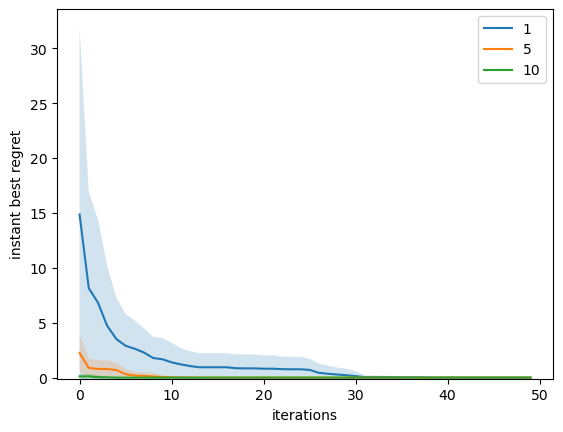

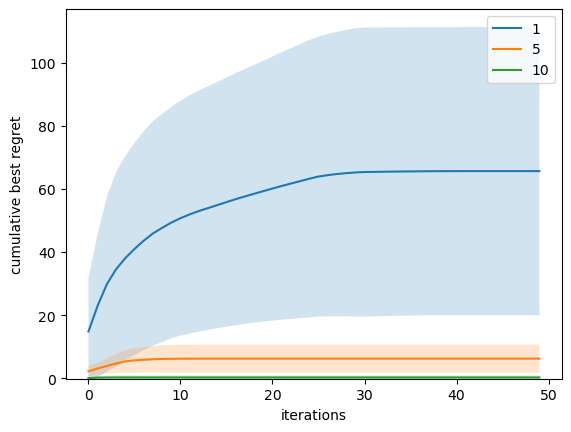

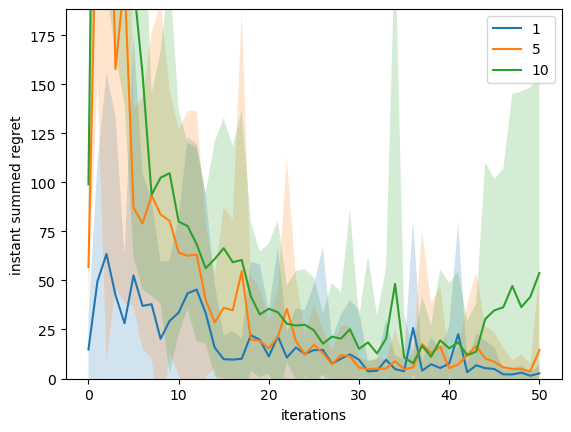

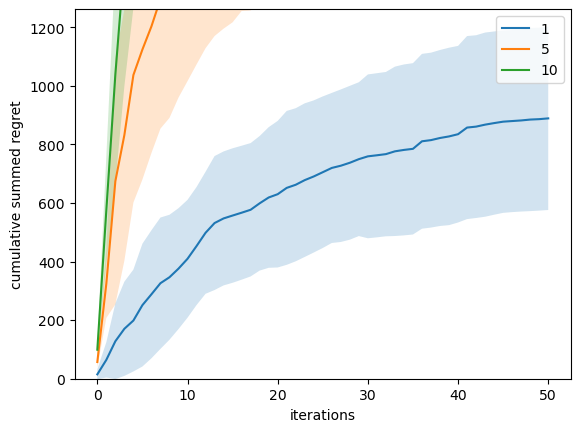

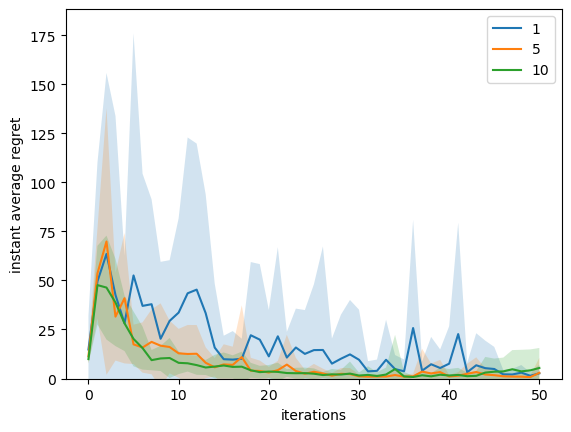

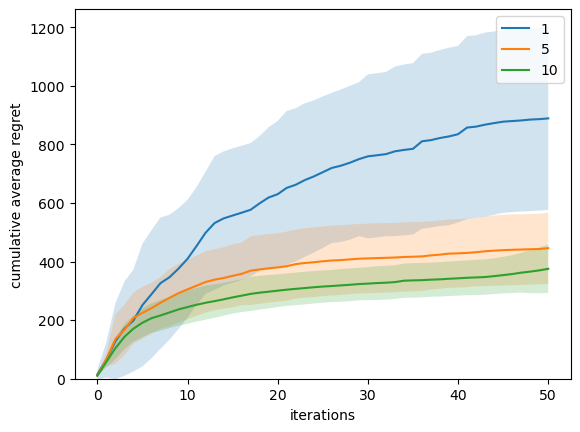

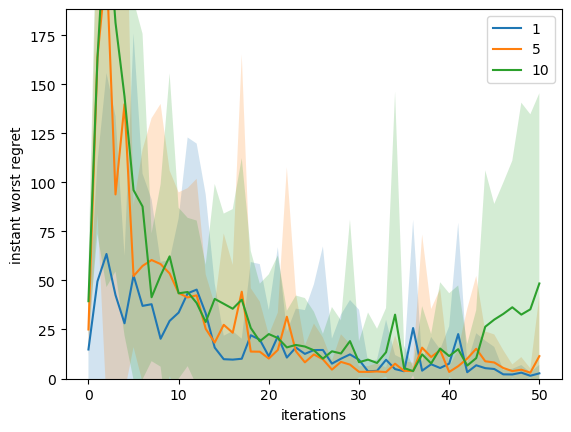

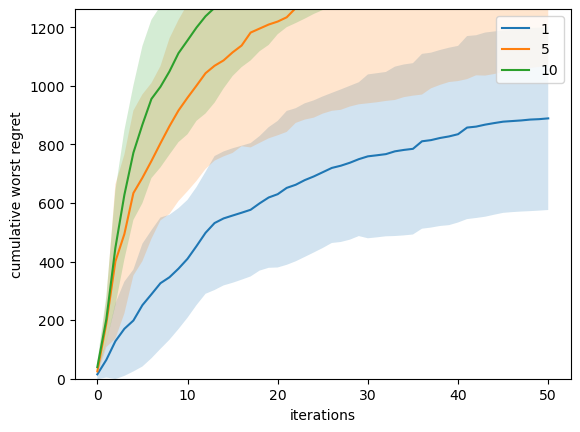

In [66]:
plotRegretsMultCaseWithVar(ros_ER,[i for i in [1]+agentSizes[0:3]])

### Random Graphs with Constant expected number of edges (Picked to be 3)

In [67]:
print('test')

test


In [ ]:
start=time.time()
numTrials=5
agentSizes=[5,10,15,20]

ackley_ER=[]
warnings.filterwarnings("ignore") #error messages of form: /opt/anaconda3/envs/saba/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
#jitter goes up to 1.0e-03

#im doing singe separately because erdos-renyi graph function doesn't work with 1 agent
ackley_oneAgent=[runBO(numAgents=1,initSize=10,totalT=50,discSize=100,eps=1,graph=np.array([[0]]),seed=j,objFunc='ackley',admissRad=.5) for j in range(numTrials**2)]
ackley_ER.append(ackley_oneAgent)
#iterate through number of agents
for i in agentSizes:
    agentDataH=[]
    for k in range(numTrials):
        ER=makeCommGraph(i,'erdos-renyi',connectProb=0.25,seed=8*k+10)
        agentDataH+=[runBO(numAgents=i,initSize=10,totalT=50,discSize=100,eps=1,graph=ER,seed=j,objFunc='ackley',admissRad=.5) for j in range(numTrials)]
    ackley_ER.append(agentDataH)
    print(f"Finished {i} agent case")

print(time.time()-start)
